In [1]:
import sys

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import scipy.stats as stats
from scipy.fft import fft, fftfreq
import scipy.signal as sig
from sklearn import linear_model
import statsmodels.api as sm

sys.path.append("../../ndsvae/")
import ndsvae as ndsv

sys.path.append("..")
import plot
import util
import plotutils as pu

%matplotlib inline

## Set matplotlib

In [2]:
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = "Arial"

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Load data

In [3]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    

def get_results(testcase, config, runs):
    modelname = "AN"
    path = f"../run/main/{testcase}/model{modelname}/{config}"
    ds = ndsv.Dataset.from_file(f"../run/main/{testcase}/dataset.npz")
    run = util.select_run(testcase, modelname, config, [0,1])
    surr   = ndsv.GeneratedData.from_file(f"../run/main/{testcase}/surrogates.npz")
    sims   = ndsv.GeneratedData.from_file(f"{path}/run{run:02d}/simulations.npz")
    params = ndsv.Params.from_file(f"{path}/run{run:02d}/parameters.npz")
        
    return dotdict(ds=ds, sims=sims, params=params, surr=surr)

resh = get_results("hopf",     "ns_2_mreg_2_msub_1_nf_32", [0,1])
resp = get_results("pmfm_avg", "ns_2_mreg_2_msub_1_nf_32", [0,1])

nsub = 8
nreg = 68

In [4]:
def pvaltext(p):
    return f"$p$ = {p:.1e}" if p > 1e-10 else "$p$ < 1e-10"


def rhostats(x, y, ax, pos, title=None, **kwargs):
    rho, pval = stats.spearmanr(x, y)
    text =  f"$\\rho$ = {np.abs(rho):.2f}\n{pvaltext(pval)}"
    if title is not None:
        text = title + "\n" + text
    
    plt.text(pos[0], pos[1], text, transform=ax.transAxes, fontsize=8, **kwargs)

## Hopf parameters

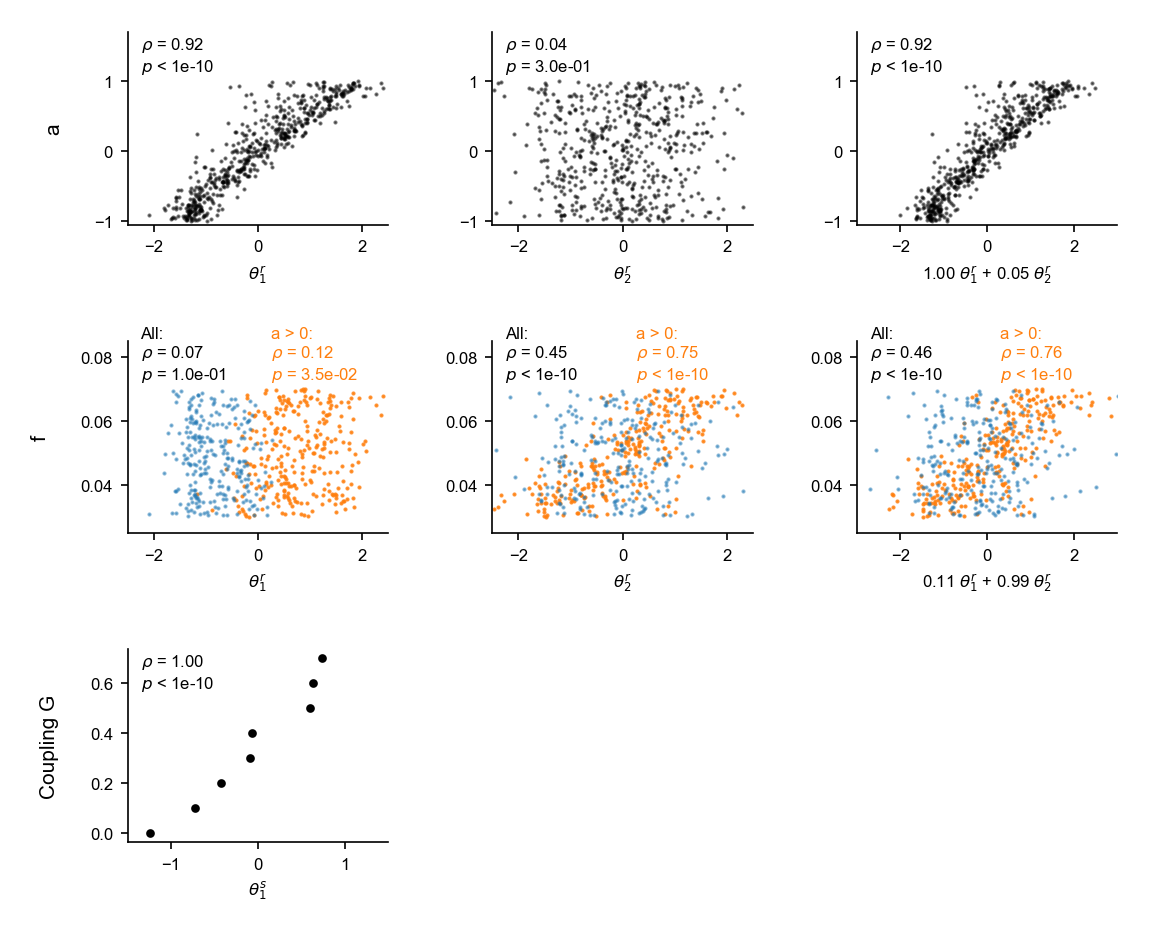

In [5]:
# Random sample of parameters
np.random.seed(42)

treg = np.random.normal(resh.params.thetareg[:,:,:,0], resh.params.thetareg[:,:,:,1]).reshape((nsub*nreg,-1))
tregm = resh.params.thetareg[:,:,:,0].reshape((nsub*nreg,-1))
a = resh.ds.thetareg[:,:,0].reshape((nsub*nreg))
f = resh.ds.thetareg[:,:,1].reshape((nsub*nreg))
mask = a > 0.0

tsub = np.random.normal(resh.params.thetasub[:,:,0], resh.params.thetasub[:,:,1])
G = resh.ds.thetasub[:,0]

plt.figure(figsize=(7.5, 6), dpi=150)

gs = GridSpec(nrows=3, ncols=3, left=0.1, right=0.98, top=0.98, bottom=0.08, hspace=0.6, wspace=0.4)

# First two rows: f and a
for j, (data, label) in enumerate([(a, "a"), (f, "f")]):

    for i in range(2):
        ax = plt.subplot(gs[j,i])
        if label == 'f':
            plt.scatter(treg[:,i][mask], data[mask], color='tab:orange', s=1, alpha=0.8)
            plt.scatter(treg[:,i][~mask], data[~mask], color='tab:blue', s=1, alpha=0.5)
        else:
            plt.scatter(treg[:,i], data, color='k', s=1, alpha=0.5)
            
        plt.xlim(-2.5, 2.5)
        plt.xticks([-2,0,2])
        plt.ylim((-1.05, 1.7) if label == 'a' else (0.025, 0.085))
        
        plt.xlabel(f"$\\theta^r_{i+1}$")
        pu.bottomleft_spines(ax)
        rhostats(treg[:,i], data, ax, (0.05, 0.8), title='All:' if label == 'f' else None)
        if label == 'f':
            rhostats(treg[:,i][mask], data[mask], ax, (0.55, 0.8), color='tab:orange', title='a > 0:')
        if i == 0:
            plt.ylabel(f"{label}\n", fontsize=10)

    linreg = linear_model.LinearRegression(normalize=True).fit(tregm, data)
    coef = linreg.coef_/np.linalg.norm(linreg.coef_)
    tregp = np.sum(treg * coef, axis=1)

    ax = plt.subplot(gs[j,2])
    if label == 'f':
        plt.scatter(tregp[mask], data[mask], color='tab:orange', s=1, alpha=0.8)
        plt.scatter(tregp[~mask], data[~mask], color='tab:blue', s=1, alpha=0.5)
    else:
        plt.scatter(tregp, data, color='k', s=1, alpha=0.5)
    
    plt.xlim(-3, 3)
    plt.xticks([-2,0,2])
    plt.xlabel(f"{coef[0]:.2f} $\\theta^r_1$ + {coef[1]:.2f} $\\theta^r_2$")
    plt.ylim((-1.05, 1.7) if label == 'a' else (0.025, 0.085))
    
    rhostats(tregp, data, ax, (0.05, 0.8), title='All:' if label == 'f' else None)
    if label == 'f':
        rhostats(tregp[mask], data[mask], ax, (0.55, 0.8), color='tab:orange', title='a > 0:')

    pu.bottomleft_spines(ax)


# Second row: G
ax = plt.subplot(gs[2,0])
plt.scatter(tsub[:,0], G, color='k', s=10)
plt.xlim(-1.5, 1.5)
# plt.xticks([-0.2,0,0.2])
plt.xlabel(f"$\\theta^s_{1}$")
pu.bottomleft_spines(ax)
rhostats(tsub[:,0], G, ax, (0.6, 0.8) if i == 0 else (0.05, 0.8))
plt.ylabel("Coupling G\n", fontsize=10)


bg = pu.Background(visible=False)
plt.savefig("img/Fig_hopf_params.pdf")

## pMFM parameters

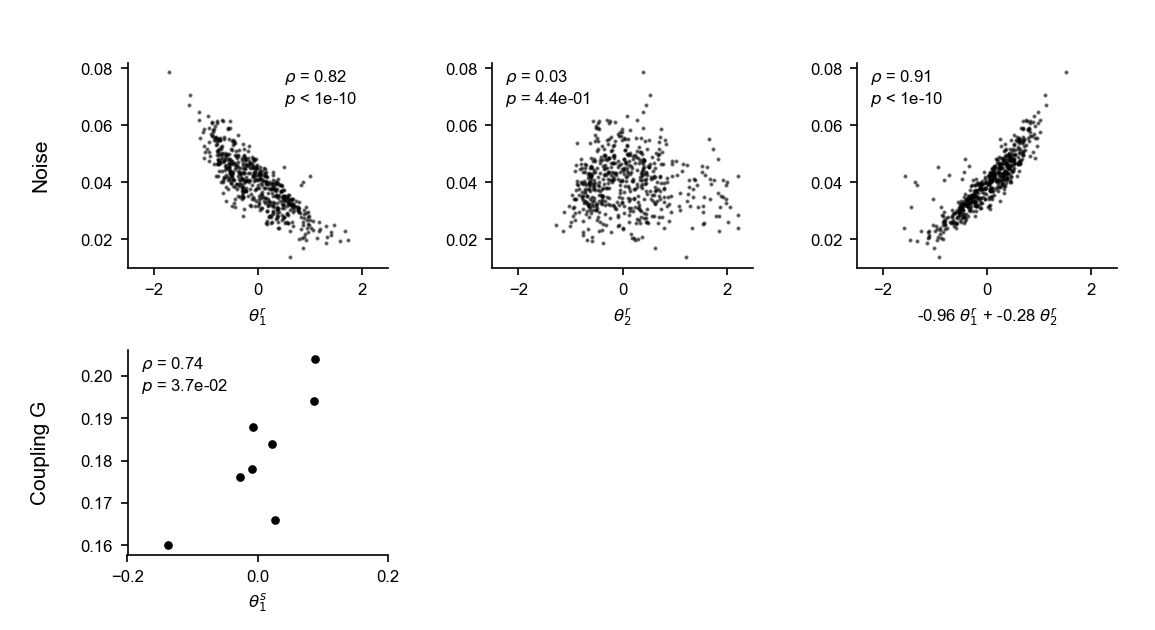

In [6]:

# Random sample of parameters
np.random.seed(42)

treg = np.random.normal(resp.params.thetareg[:,:,:,0], resp.params.thetareg[:,:,:,1]).reshape((nsub*nreg,-1))
tregm = resp.params.thetareg[:,:,:,0].reshape((nsub*nreg,-1))
noise = resp.ds.thetareg[:,:,0].reshape((nsub*nreg))

tsub = np.random.normal(resp.params.thetasub[:,:,0], resp.params.thetasub[:,:,1])
G = resp.ds.thetasub[:,0]

plt.figure(figsize=(7.5, 4), dpi=150)

gs = GridSpec(nrows=2, ncols=3, left=0.1, right=0.98, top=0.92, bottom=0.10, hspace=0.4, wspace=0.4)


# First row: noise
for i in range(2):
    ax = plt.subplot(gs[0,i])
    plt.scatter(treg[:,i], noise, color='k', s=1, alpha=0.5)
    plt.xlim(-2.5, 2.5)
    plt.ylim(0.01, 0.082)
    plt.xticks([-2,0,2])
    plt.xlabel(f"$\\theta^r_{i+1}$")
    pu.bottomleft_spines(ax)
    rhostats(treg[:,i], noise, ax, (0.6, 0.8) if i == 0 else (0.05, 0.8))    
    if i == 0:
        plt.ylabel("Noise\n", fontsize=10)
    

ax = plt.subplot(gs[0,2])

linreg = linear_model.LinearRegression(normalize=True).fit(tregm, noise)
coef = linreg.coef_/np.linalg.norm(linreg.coef_)
tregp = np.sum(treg * coef, axis=1)

plt.scatter(tregp, noise, color='k', s=1, alpha=0.5)
plt.xlim(-2.5, 2.5)
plt.xticks([-2,0,2])
plt.ylim(0.01, 0.082)
plt.xlabel(f"{coef[0]:.2f} $\\theta^r_1$ + {coef[1]:.2f} $\\theta^r_2$")
rhostats(tregp, noise, ax, (0.05, 0.8))

pu.bottomleft_spines(ax)


# Second row: G
ax = plt.subplot(gs[1,0])
plt.scatter(tsub[:,0], G, color='k', s=10)
plt.xlim(-0.2, 0.2)
plt.xticks([-0.2,0,0.2])
plt.xlabel(f"$\\theta^s_{1}$")
pu.bottomleft_spines(ax)
rhostats(tsub[:,0], G, ax, (0.6, 0.8) if i == 0 else (0.05, 0.8))
plt.ylabel("Coupling G\n", fontsize=10)


bg = pu.Background(visible=False)
plt.savefig("img/Fig_pmfm_params.pdf")